<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Inteligência Artificial Para Visão Computacional</font>
## <font color='blue'>Projeto 5</font>
## <font color='blue'>Vision Transformers (ViT) Para Prever Qualidade de Alimentos em Plantações Agrícolas</font>

## Instalando e Carregando Pacotes

In [1]:
# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [3]:
!pip install -q accelerate

In [4]:
!pip install -q torch

In [5]:
!pip install -q transformers

In [6]:
!pip install -q datasets

In [7]:
# Imports
import requests
import torch
import datasets
import transformers
import numpy as np
from datasets import load_dataset, load_metric
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" 

Author: Data Science Academy



### Carregando os Dados Para o Nosso Caso de Uso

https://huggingface.co/datasets/beans

In [9]:
# Carrega os dados
dados = load_dataset("beans")

In [10]:
print(dados)

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})


In [11]:
# Extrai o dicionário de uma imagem
exemplo = dados['train'][315]

In [12]:
exemplo

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/angular_leaf_spot/angular_leaf_spot_train.72.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500>,
 'labels': 0}

In [13]:
# Extrai a imagem
image = exemplo['image']

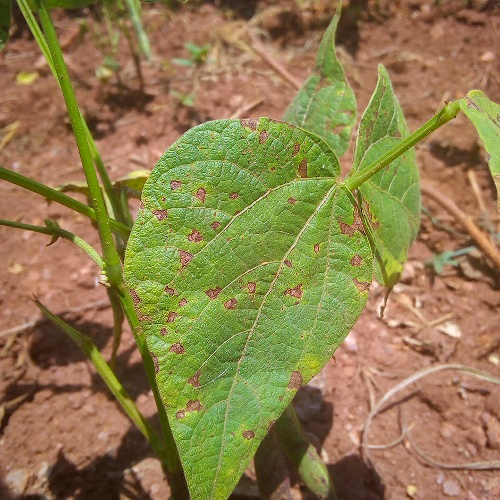

In [14]:
image

Labels

In [15]:
# Extrai os labels
labels = dados['train'].features['labels']

In [16]:
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [17]:
# Label da imagem de exemplo
labels.int2str(exemplo['labels'])

'angular_leaf_spot'

### Carregando e Aplicando o ViT Feature Extractor
<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
Assim como outras redes neurais treinadas em tarefas de classificação de imagens, o Vision Transformer (ViT) pode ser usado como um extrator de características para imagens. Isso significa que a saída de uma das camadas do modelo (normalmente a última camada antes da camada de classificação) é usada como uma representação vetorial de alto nível da imagem de entrada.

Essa representação pode ser usada em uma variedade de tarefas, como agrupamento de imagens, detecção de anomalias, transferência de estilo, entre outros. A ideia é que, ao ser treinado em uma grande quantidade de imagens, o ViT aprenda a capturar as características semânticas e visuais importantes em seus embeddings.

A saída do extrator de características do ViT pode ser considerada como um "resumo" de alto nível da imagem, que retém as informações visuais e semânticas mais relevantes enquanto descarta detalhes menos importantes. Por exemplo, pode reter informações sobre a presença de determinados objetos ou características na imagem, sua localização relativa, cor, textura, etc.

Em muitos casos, essas representações aprendidas por modelos treinados em grandes conjuntos de dados, como o ImageNet, podem ser úteis mesmo para tarefas que são bastante diferentes das tarefas originais de treinamento do modelo. Isso é conhecido como "transferência de aprendizado", e é uma maneira eficaz de aproveitar modelos pré-treinados para tarefas onde os dados podem ser mais escassos.

Portanto, o ViT Feature Extractor serve para transformar imagens de entrada em representações vetoriais de alto nível que podem ser usadas para uma variedade de tarefas além da classificação de imagens.

https://huggingface.co/google/vit-base-patch16-224-in21k

In [18]:
# Repositório do ViT pré-treinado
repo_id = "google/vit-base-patch16-224-in21k"

In [19]:
# Importa o ViTFeatureExtractor
feature_extractor = ViTFeatureExtractor.from_pretrained(repo_id)

In [20]:
print(feature_extractor)

ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [21]:
# Processamento de uma imagem
feature_extractor(image, return_tensors = "pt")

{'pixel_values': tensor([[[[-0.6078, -0.5922, -0.6078,  ..., -0.4431, -0.4196, -0.3725],
          [-0.6627, -0.6392, -0.6157,  ..., -0.4353, -0.4196, -0.3176],
          [-0.6941, -0.6706, -0.6471,  ..., -0.3255, -0.2941, -0.3020],
          ...,
          [-0.5451, -0.4902, -0.4353,  ...,  0.3490,  0.3490,  0.2314],
          [-0.5294, -0.4980, -0.4667,  ...,  0.3020,  0.2941,  0.2549],
          [-0.5137, -0.4980, -0.4902,  ...,  0.3490,  0.4118,  0.3569]],

         [[-0.5451, -0.5059, -0.4902,  ..., -0.6392, -0.6078, -0.5608],
          [-0.6078, -0.5608, -0.5137,  ..., -0.6471, -0.5922, -0.4902],
          [-0.6314, -0.6078, -0.5843,  ..., -0.5373, -0.5059, -0.5059],
          ...,
          [-0.7255, -0.6863, -0.6549,  ..., -0.0588, -0.0745, -0.1922],
          [-0.7098, -0.6863, -0.6627,  ..., -0.0824, -0.1137, -0.1686],
          [-0.6941, -0.6784, -0.6706,  ..., -0.0275,  0.0196, -0.0431]],

         [[-0.8980, -0.8745, -0.8902,  ..., -0.7333, -0.7333, -0.7020],
          [-0

In [22]:
# Retorna as chaves
feature_extractor(image, return_tensors = "pt").keys()

dict_keys(['pixel_values'])

In [23]:
# Pixel tensor shape por image
feature_extractor(image, return_tensors = "pt")['pixel_values'].shape

torch.Size([1, 3, 224, 224])

### Processamento das Imagens

In [24]:
# Função de processamento de imagem
def dsa_processa_exemplo(example):
    inputs = feature_extractor(example['image'], return_tensors = 'pt')
    inputs['labels'] = example['labels']
    return inputs

In [25]:
# Testando a função
dsa_processa_exemplo(dados['train'][0])

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

In [26]:
# Função para o mapeamento de lotes de imagens e aplicação do ViTFeatureExtractor
def dsa_mapeia_lotes(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors = 'pt')
    inputs['labels'] = example_batch['labels']
    return inputs

In [27]:
# Prepara os dados
dados_mapeados = dados.with_transform(dsa_mapeia_lotes)

In [28]:
# Visualiza um exemplo
dados_mapeados['train'][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

In [29]:
# Função para combinar amostras
def dsa_collate_fn(batch):

    return {"pixel_values": torch.stack([x['pixel_values'] for x in batch]),
            "labels": torch.tensor([x["labels"] for x in batch])}

A função collate_fn acima é usada para combinar múltiplas amostras de dados em um único lote durante o carregamento de dados em um DataLoader do PyTorch. Essa função é especialmente útil quando as amostras individuais não são diretamente combináveis, por exemplo, quando elas têm diferentes formas ou tipos.

Neste caso, a função collate_fn está tomando uma lista de amostras de dados (onde cada amostra é um dicionário contendo 'pixel_values' e 'labels') e retorna um único dicionário que representa um lote de dados.

Aqui estão os detalhes do que a função faz:

torch.stack([x['pixel_values'] for x in batch]): Esta linha está pegando a lista de tensor de 'pixel_values' de todas as amostras no lote e as empilhando em um único tensor. O resultado é um tensor 4D, onde a primeira dimensão representa a amostra dentro do lote, e as outras três dimensões representam os canais, altura e largura da imagem, respectivamente.

torch.tensor([x["labels"] for x in batch]): Esta linha está pegando a lista de 'labels' de todas as amostras no lote e as transformando em um único tensor. O resultado é um tensor 1D, onde cada elemento representa o rótulo da respectiva amostra no lote.

### Construção do Módulo de Treino do ViT

In [30]:
# Métrica a ser usada
metric = load_metric("accuracy")

In [31]:
# Cálculo da métrica
def dsa_calcula_metrica(prediction):
    return metric.compute(predictions = np.argmax(prediction.predictions, axis = 1),
                          references = prediction.label_ids)

In [32]:
# Labels
labels = dados['train'].features['labels'].names

In [33]:
print(labels)

['angular_leaf_spot', 'bean_rust', 'healthy']


In [34]:
# Importa o modelo ViTForImageClassification indicandos os novos labels que serão usados
modelo = ViTForImageClassification.from_pretrained(repo_id,
                                                   num_labels = len(labels),
                                                   id2label = {str(i):c for i, c in enumerate(labels)},
                                                   label2id = {c:str(i) for i,c in enumerate(labels)})

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Esta mensagem acima está dizendo que você está inicializando um modelo ViTForImageClassification (um modelo de classificação de imagem Vision Transformer) a partir de um modelo pré-treinado (google/vit-base-patch16-224-in21k). No entanto, nem todos os pesos do modelo pré-treinado estão sendo usados na inicialização e alguns pesos do modelo ViTForImageClassification estão sendo inicializados do zero.

Há dois pontos principais aqui:

Alguns pesos do checkpoint do modelo ('pooler.dense.bias', 'pooler.dense.weight') não foram utilizados na inicialização do ViTForImageClassification. Isso pode ser esperado se você estiver inicializando o ViTForImageClassification a partir do checkpoint de um modelo treinado em outra tarefa ou com outra arquitetura. Se o modelo pré-treinado fosse exatamente idêntico à arquitetura que você está inicializando, você esperaria que todos os pesos fossem usados, e a mensagem informaria que algo está errado se isso não acontecesse.

Alguns pesos do ViTForImageClassification ('classifier.bias', 'classifier.weight') não foram inicializados a partir do checkpoint do modelo e foram recém-inicializados. Isso significa que esses componentes específicos do modelo não receberam pesos do modelo pré-treinado e, em vez disso, foram inicializados, provavelmente com alguma forma de inicialização aleatória.

A mensagem termina sugerindo que você provavelmente deve treinar (ou seja, fazer um "fine-tuning") este modelo em uma tarefa antes de usá-lo para predições e inferências. Isso ocorre porque, embora o modelo tenha sido parcialmente inicializado com pesos de um modelo pré-treinado, ele ainda tem alguns pesos que foram inicializados aleatoriamente e, portanto, precisam ser ajustados para a tarefa específica que você deseja resolver.

### Argumentos de Treino

In [35]:
# Argumentos de treino
training_args = TrainingArguments(output_dir = "resultados",
                                  evaluation_strategy = 'steps',
                                  num_train_epochs = 4,
                                  learning_rate = 2e-4,
                                  remove_unused_columns = False,
                                  load_best_model_at_end = True)

Aqui está uma explicação de cada um dos parâmetros acima:

**output_dir**: Especifica o diretório onde os resultados do treinamento, como os modelos salvos e os logs, serão armazenados. 

**evaluation_strategy**: Define como a avaliação é feita durante o treinamento. O valor 'steps' indica que a avaliação ocorrerá em intervalos regulares de passos de treinamento, conforme definido por outros parâmetros como eval_steps.

**num_train_epochs**: Indica o número de vezes que o conjunto de dados de treinamento será iterado completamente. Neste caso, o treinamento ocorrerá ao longo de 4 épocas completas.

**learning_rate**: Define a taxa de aprendizagem inicial usada pelo otimizador. O valor 2e-4 ou 0.0002 é uma escolha comum que determina a magnitude dos ajustes feitos aos pesos do modelo em cada passo de treinamento.

**remove_unused_columns**: Um booleano que, quando definido como False, não remove colunas de dados não usadas automaticamente. Isso pode ser útil para manter os dados originais intactos por quaisquer motivos, como referência futura ou processamento adicional.

**load_best_model_at_end**: Quando configurado como True, o modelo com o melhor desempenho na avaliação é carregado no final do treinamento. Isso é útil para garantir que o modelo retornado após o treinamento seja o que teve o melhor desempenho, conforme avaliado por uma métrica especificada.

### Instância de Treino do Modelo

In [36]:
# Trainer
trainer = Trainer(model = modelo,
                  args = training_args,
                  data_collator = dsa_collate_fn,
                  compute_metrics = dsa_calcula_metrica,
                  train_dataset = dados_mapeados['train'],
                  eval_dataset = dados_mapeados['validation'],
                  tokenizer = feature_extractor)

A instância Trainer é configurada com vários argumentos essenciais para o treinamento de modelos de aprendizado de máquina, usando a biblioteca Hugging Face Transformers. Cada argumento tem uma função específica na configuração e execução do treinamento:

**model**: Especifica o modelo de aprendizado de máquina que será treinado. No caso, o valor modelo se refere à instância do modelo que você deseja treinar.

**args**: Refere-se aos argumentos de treinamento que configuram como o treinamento deve ser executado. Esses argumentos são os que você detalhou anteriormente (como num_train_epochs, learning_rate, etc.), agrupados na instância training_args.

**data_collator**: Uma função ou objeto data_collator é usado para agrupar e formatar corretamente os dados antes de serem alimentados ao modelo durante o treinamento. 

**compute_metrics**: Esta função, especificada aqui como dsa_calcula_metrica, é usada para calcular as métricas de desempenho do modelo após cada etapa de avaliação durante o treinamento. Ela ajuda a monitorar o quão bem o modelo está aprendendo e se ajustando aos dados de treinamento.

**train_dataset e eval_dataset**: Estes argumentos referem-se aos conjuntos de dados usados para o treinamento e validação, respectivamente. 

**tokenizer**: Especifica o tokenizer ou feature extractor usado para processar ou tokenizar os dados antes de serem fornecidos ao modelo. feature_extractor é a ferramenta usada para transformar os dados brutos em um formato que o modelo pode entender e processar eficientemente.

### Treinamento e Avaliação do Modelo

In [37]:
%%time
dsa_resultado_treino = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.117400,0.022885,0.992481


CPU times: user 3min 35s, sys: 20min 29s, total: 24min 5s
Wall time: 1min 41s


In [38]:
# Salva o modelo em disco
trainer.save_model('modelos')

In [39]:
# Log das métricas
trainer.log_metrics('train', dsa_resultado_treino.metrics)

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1131
  train_runtime            =  0:01:40.97
  train_samples_per_second =      40.962
  train_steps_per_second   =        5.15


In [40]:
# Salva as métricas
trainer.save_metrics('train', dsa_resultado_treino.metrics)

In [41]:
# Avaliação do modelo
metrics = trainer.evaluate(dados_mapeados['validation'])
trainer.log_metrics('eval', metrics)
trainer.save_metrics('eval', metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0229
  eval_runtime            = 0:00:01.31
  eval_samples_per_second =    101.516
  eval_steps_per_second   =     12.976


### Deploy do Modelo

https://www.greenlife.co.ke/wp-content/uploads/2022/04/disease_bean_angular_leaf_spot.jpg

In [42]:
# URL de uma imagem (experimente outras imagens)
url = 'https://www.greenlife.co.ke/wp-content/uploads/2022/04/disease_bean_angular_leaf_spot.jpg'

In [43]:
# Carrega a imagem
image = Image.open(requests.get(url, stream = True).raw)

In [44]:
# Aplica o extrator
inputs = feature_extractor(images = image, return_tensors = "pt")

In [45]:
# Coloca a imagem no mesmo device do modelo
inputs = {name: tensor.to(trainer.args.device) for name, tensor in inputs.items()}

In [46]:
inputs

{'pixel_values': tensor([[[[ 0.6157,  0.6078,  0.6314,  ..., -0.0118, -0.0275, -0.0353],
           [ 0.6000,  0.6000,  0.6078,  ..., -0.0118, -0.0431, -0.0667],
           [ 0.6000,  0.6157,  0.5922,  ..., -0.0039, -0.0196, -0.0824],
           ...,
           [ 0.4353,  0.4039,  0.4118,  ...,  0.0275,  0.0039,  0.0118],
           [ 0.4275,  0.4196,  0.4353,  ...,  0.0431,  0.0039,  0.0039],
           [ 0.4039,  0.4039,  0.4275,  ...,  0.0431,  0.0118, -0.0118]],
 
          [[ 0.4118,  0.4275,  0.4510,  ..., -0.1294, -0.1451, -0.1529],
           [ 0.3961,  0.4275,  0.4275,  ..., -0.1137, -0.1529, -0.1765],
           [ 0.4118,  0.4353,  0.4118,  ..., -0.1137, -0.1216, -0.2000],
           ...,
           [ 0.2000,  0.1922,  0.1922,  ..., -0.0980, -0.1137, -0.1059],
           [ 0.1843,  0.2078,  0.2157,  ..., -0.0824, -0.1294, -0.1216],
           [ 0.1608,  0.2235,  0.2235,  ..., -0.0824, -0.1373, -0.1294]],
 
          [[ 0.0353,  0.0353,  0.0902,  ..., -0.4824, -0.4902, -0.4824

In [47]:
# Coloca o modelo em modo de avaliação
trainer.model.eval()

# Desliga os gradientes para a inferência
with torch.no_grad():
    outputs = trainer.model(**inputs)

In [48]:
# Extrai os logits
logits = outputs.logits

In [49]:
# Extrai o logit de maior valor para a imagem
class_index = logits.argmax()

In [50]:
print(class_index)

tensor(0, device='mps:0')


In [51]:
# Extrai o valor a partir do tensor
valor = class_index.item()
valor

0

In [52]:
# Define o mapeamento original (está na documentação do dataset bean)
mapeamento_classe = {
  "angular_leaf_spot": 0,
  "bean_rust": 1,
  "healthy": 2,
}

In [53]:
# Cria um mapeamento reverso
reverse_mapping = {v: k for k, v in mapeamento_classe.items()}
reverse_mapping

{0: 'angular_leaf_spot', 1: 'bean_rust', 2: 'healthy'}

In [54]:
# Usa o mapeamento reverso para obter o nome da classe
class_name = reverse_mapping.get(valor)

In [55]:
print("A imagem foi classificada como:", class_name)

A imagem foi classificada como: angular_leaf_spot


In [56]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [57]:
#%watermark -v -m

In [58]:
#%watermark --iversions

# Fim